## BERT Model Creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from nltk.tokenize import RegexpTokenizer, word_tokenize
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [7]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
from numpy import load

In [21]:
X_train_bvect = load('../data/X_train_bvect.npy')
X_test_bvect = load('../data/X_test_bvect.npy')

In [22]:
X_train_reshape = X_train_bvect.reshape(-1,768,1)
X_test_reshape = X_test_bvect.reshape(-1,768,1)

In [23]:
y_train_cat = load('../data/y_train_cat.npy')
y_test_cat = load('../data/y_test_cat.npy')

In [27]:
model_l = Sequential()

model_l.add(Conv1D(32, 7, activation = 'relu'))
model_l.add(MaxPooling1D())
model_l.add(Bidirectional(LSTM(24)))
model_l.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_l.add(Dropout(0.5))
model_l.add(Dense(64,activation='relu',kernel_regularizer=l2(0.001)))
model_l.add(Dropout(0.5))
model_l.add(Dense(32,activation='relu',kernel_regularizer=l2(0.001)))

model_l.add(Dense(1,activation='sigmoid'))

In [28]:
model_l.compile(optimizer='nadam', metrics=['accuracy'], loss='binary_crossentropy')

In [29]:
history_l = model_l.fit(X_train_reshape, y_train_cat, validation_data=(X_test_reshape,y_test_cat), epochs=75)

Epoch 1/75
1500/1500 [==============================] - 186s 124ms/step - loss: 0.5554 - accuracy: 0.7723 - val_loss: 0.4604 - val_accuracy: 0.8054
Epoch 2/75
1500/1500 [==============================] - 175s 117ms/step - loss: 0.4299 - accuracy: 0.8250 - val_loss: 0.3925 - val_accuracy: 0.8363
Epoch 3/75
1500/1500 [==============================] - 178s 119ms/step - loss: 0.3885 - accuracy: 0.8418 - val_loss: 0.3783 - val_accuracy: 0.8442
Epoch 4/75
1500/1500 [==============================] - 179s 119ms/step - loss: 0.3778 - accuracy: 0.8455 - val_loss: 0.4050 - val_accuracy: 0.8325
Epoch 5/75
1500/1500 [==============================] - 178s 119ms/step - loss: 0.3716 - accuracy: 0.8468 - val_loss: 0.3641 - val_accuracy: 0.8467
Epoch 6/75
1500/1500 [==============================] - 174s 116ms/step - loss: 0.3642 - accuracy: 0.8523 - val_loss: 0.3556 - val_accuracy: 0.8508
Epoch 7/75
1500/1500 [==============================] - 174s 116ms/step - loss: 0.3565 - accuracy: 0.8549 - val_

In [31]:
model_l.save('../data/model_l.hd')

INFO:tensorflow:Assets written to: ../data/model_l.hd\assets


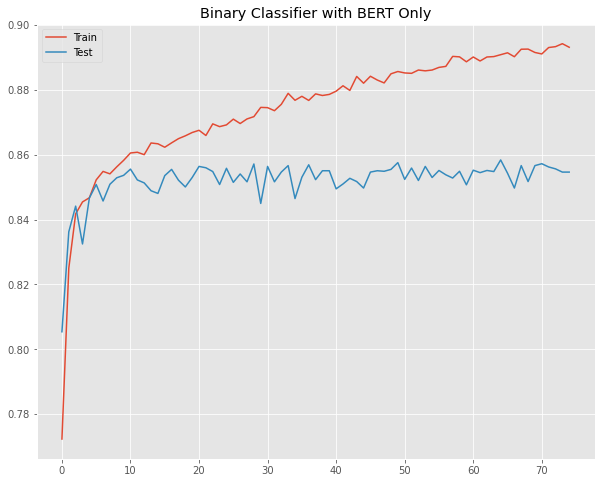

In [36]:
plt.figure(figsize=(10,8))
plt.plot(history_l.history['accuracy'], label='Train')
plt.plot(history_l.history['val_accuracy'], label='Test')
plt.title('Binary Classifier with BERT Only')
plt.legend()

### Model Evaluation

In [8]:
model_lr = load_model('../data/model_l.hd/')

In [9]:
X_test = load('../data/X_test_bvect.npy').reshape(-1,768,1)
y_test = load('../data/y_test_cat.npy')

In [10]:
preds = model_lr.predict_classes(X_test)
preds

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [16]:
y_test

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [17]:
preds = preds.reshape(1,-1).ravel()

In [18]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [19]:
cm = confusion_matrix(y_test,preds.ravel())
cm

array([[5083,  925],
       [ 819, 5173]], dtype=int64)

Text(69.0, 0.5, 'True')

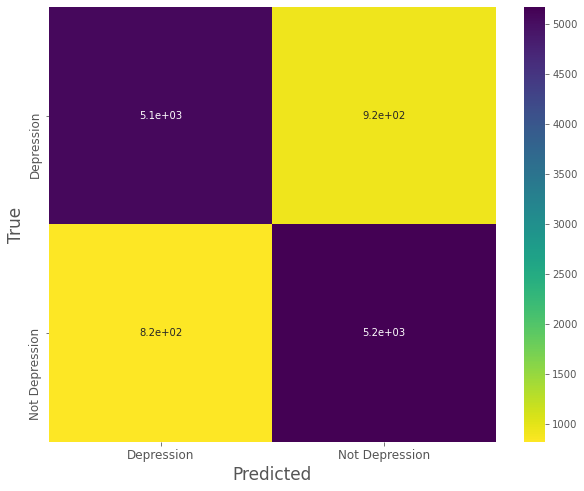

In [25]:
plt.figure(figsize=(10,8))
g = sns.heatmap(cm, annot=True, cmap='viridis_r'); #annot=True to annotate cells
g.xaxis.set_ticklabels(['Depression', 'Not Depression'],size=12)
g.yaxis.set_ticklabels(['Depression', 'Not Depression'],size=12)

g.set_xlabel("Predicted",size=17)
g.set_ylabel("True",size=17)
# X-axis is predicted labels
# y-axis is true labels

In [21]:
tn, fp, fn, tp = cm.ravel()

In [22]:
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [23]:
clf_dict = {'recall':recall,'specificity':specificity,'precision':precision,'accuracy':accuracy,'F1':f1_score}

In [24]:
clf_df = pd.DataFrame(clf_dict,index=['Scores']).T
clf_df

,Scores
recall,0.863318
specificity,0.846039
precision,0.848311
accuracy,0.854667
F1,0.855749
